## Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import glob
import os

## Import Data

In [4]:
# Read in the data
path = 'Data/'
files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]

df = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
df.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,y,floorRange,area,street,contractDate,typeOfArea
0,1,Freehold,RCR,3,5,NaN,20914.198897,Strata Terrace,1880000,LANDED HOUSING DEVELOPMENT,30589.107079,-,186.0,NEO PEE TECK LANE,321,Strata
1,1,Freehold,RCR,3,5,NaN,20914.198897,Terrace,4600000,LANDED HOUSING DEVELOPMENT,30589.107079,-,257.0,NEO PEE TECK LANE,522,Land
2,1,Freehold,RCR,3,5,NaN,NaN,Semi-detached,5200000,LANDED HOUSING DEVELOPMENT,NaN,-,308.0,ZEHNDER ROAD,921,Land
3,1,Freehold,RCR,3,5,NaN,NaN,Semi-detached,5188888,LANDED HOUSING DEVELOPMENT,NaN,-,228.4,ZEHNDER ROAD,724,Land
4,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,Apartment,2065000,AUREA,NaN,21-25,66.0,BEACH ROAD,925,Strata


In [5]:
# Unique values in each column
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")
print("\n")
numeric_df = df.select_dtypes(include=['int64', 'float64'])
non_numeric_df = df.select_dtypes(exclude=['int64', 'float64'])

print("Numeric columns available:")
print(numeric_df.columns.tolist())
print(f"\nShape: {numeric_df.shape}")

print("Non-numeric columns available:")
print(non_numeric_df.columns.tolist())
print(f"\nShape: {non_numeric_df.shape}")


noOfUnits: 26
tenure: 140
marketSegment: 3
typeOfSale: 3
district: 28
nettPrice: 241
x: 3701
propertyType: 9
price: 18011
project: 3021
y: 3701
floorRange: 17
area: 4028
street: 1662
contractDate: 61
typeOfArea: 2


Numeric columns available:
['noOfUnits', 'typeOfSale', 'district', 'nettPrice', 'x', 'price', 'y', 'area', 'contractDate']

Shape: (143221, 9)
Non-numeric columns available:
['tenure', 'marketSegment', 'propertyType', 'project', 'floorRange', 'street', 'typeOfArea']

Shape: (143221, 7)


## Data Cleaning

In [6]:
# Remove duplicates
df_raw = df.copy()
df = df.drop_duplicates()

In [7]:
"""
Map contractDate to Month and Year
"""
df['contractYear'] = df['contractDate'].apply(lambda x: x % 100 + 2000)
df['contractMonth'] = df['contractDate'].apply(lambda x: x // 100)

In [8]:
"""
Separate tenure into tenure duration and start year
If tenure is freehold, set duration to inf and start year to NaN
If tenure is leasehold without start year, set start year to NaN
If tenure is NaN, set both to NaN
Calculate tenure remaining as tenureDuration - (contractYear - tenureStartYear)
"""
df['tenure'] = df['tenure'].str.lower()     # Convert to lowercase for consistency
df['tenureDuration'] = df['tenure'].apply(lambda x: np.inf if 'freehold' in str(x) else int(x.split(' ')[0]) if isinstance(x, str) and len(x.split(' ')) > 1 else np.nan)      # If 'freehold' then 0, if NaN then NaN
df['tenureStartYear'] = df['tenure'].apply(lambda x: int(x.split(' ')[-1]) if isinstance(x, str) and len(x.split(' ')) > 3 else np.nan)     # If 'freehold' or '99 years lease' then nan
df['tenureRemaining'] = df.apply(lambda x: np.inf if 'freehold' in str(x['tenure']) else (x['tenureDuration'] - (x['contractYear'] - x['tenureStartYear'])) if not pd.isna(x['tenureStartYear']) else np.nan, axis=1)

In [9]:
""" 
Map propertyType to numerical values
"""
print(df['propertyType'].unique())
Mapping_PropertyType = {
    'Strata Terrace': 1,
    'Terrace': 2,
    'Semi-detached': 3,
    'Apartment': 4,
    'Condominium': 5,
    'Deteched': 6,
    'Strata Semi-detached': 7,
    'Strata Deteched': 8,
    'Executive Condominium': 9}

df['propertyType'] = df['propertyType'].map(Mapping_PropertyType)

['Strata Terrace' 'Terrace' 'Semi-detached' 'Apartment' 'Condominium'
 'Detached' 'Strata Semi-detached' 'Strata Detached'
 'Executive Condominium']


In [ ]:
""" 
Map floorRange to numerical values
If floorRange contains 'B', it indicates basement levels, so we convert them to negative integers
If floorRange is a range like '1-3', we take the upper value as the representative floor
If floorRange is NaN or '-', we set it to NaN
"""
print(df['floorRange'].unique())

df['floorRange'] = df['floorRange'].apply(lambda x: -int(x.split('-')[-1].replace('B','')) if isinstance(x,str) and 'B' in x and x.strip() not in ['-',''] else int(x.split('-')[-1]) if isinstance(x,str) and len(x.split('-')[-1])==2 and x.strip() not in ['-',''] else np.nan)

['-' '21-25' '26-30' '11-15' '16-20' '06-10' '36-40' '01-05' '31-35'
 '41-45' '56-60' '46-50' '51-55' 'B1-B5' '61-65' '66-70' '71-75']


In [11]:
""" 
Map typeOfArea to numerical values
If typeOfArea is 'Strata', map to 1
If typeOfArea is 'Land', map to 2
If typeOfArea is NaN or other values, set it to NaN
"""
print(df['typeOfArea'].unique())

df['typeOfArea'] = df['typeOfArea'].apply(lambda x: 1 if isinstance(x,str) and x == 'Strata' else 2 if isinstance(x,str) and x == 'Land' else x)

['Strata' 'Land']


In [12]:
df.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,...,floorRange,area,street,contractDate,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining
0,1,freehold,RCR,3,5,NaN,20914.198897,1.0,1880000,LANDED HOUSING DEVELOPMENT,...,NaN,186.0,NEO PEE TECK LANE,321,1,2021,3,inf,NaN,inf
1,1,freehold,RCR,3,5,NaN,20914.198897,2.0,4600000,LANDED HOUSING DEVELOPMENT,...,NaN,257.0,NEO PEE TECK LANE,522,2,2022,5,inf,NaN,inf
2,1,freehold,RCR,3,5,NaN,NaN,3.0,5200000,LANDED HOUSING DEVELOPMENT,...,NaN,308.0,ZEHNDER ROAD,921,2,2021,9,inf,NaN,inf
3,1,freehold,RCR,3,5,NaN,NaN,3.0,5188888,LANDED HOUSING DEVELOPMENT,...,NaN,228.4,ZEHNDER ROAD,724,2,2024,7,inf,NaN,inf
4,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,2065000,AUREA,...,25.0,66.0,BEACH ROAD,925,1,2025,9,99.0,2024.0,98.0


## Data Exploration

### Tenure

In [13]:
dict_tenure = df['tenureDuration'].value_counts(dropna=False).to_dict()
print(f"Unique tenure durations: {sorted(dict_tenure.items())}")

Unique tenure durations: [(60.0, 103), (70.0, 21), (85.0, 11), (93.0, 3), (99.0, 91874), (100.0, 60), (102.0, 116), (103.0, 361), (110.0, 16), (929.0, 43), (940.0, 5), (945.0, 4), (946.0, 114), (947.0, 35), (953.0, 9), (956.0, 294), (993.0, 6), (998.0, 3), (999.0, 4511), (9999.0, 18), (999999.0, 5), (inf, 36791)]


In [14]:
# Freehold
df_freehold = df[df['tenureDuration'] == np.inf]
df_freehold.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,...,floorRange,area,street,contractDate,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining
0,1,freehold,RCR,3,5,NaN,20914.198897,1.0,1880000,LANDED HOUSING DEVELOPMENT,...,NaN,186.0,NEO PEE TECK LANE,321,1,2021,3,inf,NaN,inf
1,1,freehold,RCR,3,5,NaN,20914.198897,2.0,4600000,LANDED HOUSING DEVELOPMENT,...,NaN,257.0,NEO PEE TECK LANE,522,2,2022,5,inf,NaN,inf
2,1,freehold,RCR,3,5,NaN,NaN,3.0,5200000,LANDED HOUSING DEVELOPMENT,...,NaN,308.0,ZEHNDER ROAD,921,2,2021,9,inf,NaN,inf
3,1,freehold,RCR,3,5,NaN,NaN,3.0,5188888,LANDED HOUSING DEVELOPMENT,...,NaN,228.4,ZEHNDER ROAD,724,2,2024,7,inf,NaN,inf
164,1,freehold,RCR,3,3,NaN,27660.973040,4.0,1500000,RESIDENTIAL APARTMENTS,...,5.0,93.0,YONG SIAK STREET,1020,1,2020,10,inf,NaN,inf


In [15]:
print(f"Number of freehold properties: {len(df_freehold)}")
print(f"Average price of freehold properties: ${df_freehold['price'].mean():,.2f}")
print(f"Median price of freehold properties: ${df_freehold['price'].median():,.2f}")
print(f"Max price of freehold properties: ${df_freehold['price'].max():,.2f}")
print(f"Min price of freehold properties: ${df_freehold['price'].min():,.2f}")

Number of freehold properties: 36791
Average price of freehold properties: $3,119,538.14
Median price of freehold properties: $2,180,000.00
Max price of freehold properties: $815,000,000.00
Min price of freehold properties: $460,000.00


In [16]:
# 99 years and below
df_99_and_below = df[(df['tenureDuration'] <= 99) & (df['tenureDuration'] > 0)]
df_99_and_below.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,...,floorRange,area,street,contractDate,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining
4,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,2065000,AUREA,...,25.0,66.0,BEACH ROAD,925,1,2025,9,99.0,2024.0,98.0
5,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,6010945,AUREA,...,30.0,167.0,BEACH ROAD,525,1,2025,5,99.0,2024.0,98.0
6,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,2100000,AUREA,...,30.0,66.0,BEACH ROAD,725,1,2025,7,99.0,2024.0,98.0
7,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,4267850,AUREA,...,15.0,134.0,BEACH ROAD,325,1,2025,3,99.0,2024.0,98.0
8,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,2911440,AUREA,...,15.0,93.0,BEACH ROAD,325,1,2025,3,99.0,2024.0,98.0


In [17]:
print(f"Number of tenure years 99 and below properties: {len(df_99_and_below)}")
print(f"Average price of tenure years 99 and below properties: ${df_99_and_below['price'].mean():,.2f}")
print(f"Median price of tenure years 99 and below properties: ${df_99_and_below['price'].median():,.2f}")
print(f"Max price of tenure years 99 and below properties: ${df_99_and_below['price'].max():,.2f}")
print(f"Min price of tenure years 99 and below properties: ${df_99_and_below['price'].min():,.2f}")

Number of tenure years 99 and below properties: 92012
Average price of tenure years 99 and below properties: $1,713,550.97
Median price of tenure years 99 and below properties: $1,494,000.00
Max price of tenure years 99 and below properties: $890,000,000.00
Min price of tenure years 99 and below properties: $320,000.00


In [18]:
# 100 years and above excluding freehold
df_100_and_above = df[(df['tenureDuration'] > 99)]
df_100_and_above.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,...,floorRange,area,street,contractDate,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining
0,1,freehold,RCR,3,5,NaN,20914.198897,1.0,1880000,LANDED HOUSING DEVELOPMENT,...,NaN,186.0,NEO PEE TECK LANE,321,1,2021,3,inf,NaN,inf
1,1,freehold,RCR,3,5,NaN,20914.198897,2.0,4600000,LANDED HOUSING DEVELOPMENT,...,NaN,257.0,NEO PEE TECK LANE,522,2,2022,5,inf,NaN,inf
2,1,freehold,RCR,3,5,NaN,NaN,3.0,5200000,LANDED HOUSING DEVELOPMENT,...,NaN,308.0,ZEHNDER ROAD,921,2,2021,9,inf,NaN,inf
3,1,freehold,RCR,3,5,NaN,NaN,3.0,5188888,LANDED HOUSING DEVELOPMENT,...,NaN,228.4,ZEHNDER ROAD,724,2,2024,7,inf,NaN,inf
164,1,freehold,RCR,3,3,NaN,27660.973040,4.0,1500000,RESIDENTIAL APARTMENTS,...,5.0,93.0,YONG SIAK STREET,1020,1,2020,10,inf,NaN,inf


In [19]:
print(f"Number of tenure years 100 and above properties: {len(df_100_and_above)}")
print(f"Average price of tenure years 100 and above properties: ${df_100_and_above['price'].mean():,.2f}")
print(f"Median price of tenure years 100 and above properties: ${df_100_and_above['price'].median():,.2f}")
print(f"Max price of tenure years 100 and above properties: ${df_100_and_above['price'].max():,.2f}")
print(f"Min price of tenure years 100 and above properties: ${df_100_and_above['price'].min():,.2f}")

Number of tenure years 100 and above properties: 42391
Average price of tenure years 100 and above properties: $3,104,175.17
Median price of tenure years 100 and above properties: $2,197,600.00
Max price of tenure years 100 and above properties: $815,000,000.00
Min price of tenure years 100 and above properties: $460,000.00


### Property Type

In [20]:
dict_proptype = df['propertyType'].value_counts(dropna=False).to_dict()
print(f"Unique property types: {sorted(dict_proptype.items())}")


Unique property types: [(1.0, 1189), (2.0, 5449), (3.0, 3025), (4.0, 51385), (5.0, 55567), (7.0, 408), (9.0, 15979), (nan, 1401)]


In [21]:
# Apartment
df_apartment = df[(df['propertyType'] == Mapping_PropertyType["Apartment"])]
df_apartment.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,...,floorRange,area,street,contractDate,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining
4,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,2065000,AUREA,...,25.0,66.0,BEACH ROAD,925,1,2025,9,99.0,2024.0,98.0
5,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,6010945,AUREA,...,30.0,167.0,BEACH ROAD,525,1,2025,5,99.0,2024.0,98.0
6,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,2100000,AUREA,...,30.0,66.0,BEACH ROAD,725,1,2025,7,99.0,2024.0,98.0
7,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,4267850,AUREA,...,15.0,134.0,BEACH ROAD,325,1,2025,3,99.0,2024.0,98.0
8,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,4.0,2911440,AUREA,...,15.0,93.0,BEACH ROAD,325,1,2025,3,99.0,2024.0,98.0


In [22]:
print(f"Number of apartment properties: {len(df_apartment)}")
print(f"Average price of apartment properties: ${df_apartment['price'].mean():,.2f}")
print(f"Median price of apartment properties: ${df_apartment['price'].median():,.2f}")
print(f"Max price of apartment properties: ${df_apartment['price'].max():,.2f}")
print(f"Min price of apartment properties: ${df_apartment['price'].min():,.2f}")

Number of apartment properties: 51385
Average price of apartment properties: $1,875,075.57
Median price of apartment properties: $1,610,000.00
Max price of apartment properties: $273,888,888.00
Min price of apartment properties: $340,000.00


In [23]:
# Condominium
df_condominium = df[(df['propertyType'] == Mapping_PropertyType["Condominium"])]
df_condominium.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,...,floorRange,area,street,contractDate,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining
36,1,99 yrs lease commencing from 2007,CCR,3,4,NaN,28382.47067,5.0,3180000,TURQUOISE,...,5.0,194.0,COVE DRIVE,1020,1,2020,10,99.0,2007.0,86.0
37,1,99 yrs lease commencing from 2007,CCR,3,4,NaN,28382.47067,5.0,2800000,TURQUOISE,...,5.0,223.0,COVE DRIVE,221,1,2021,2,99.0,2007.0,85.0
38,1,99 yrs lease commencing from 2007,CCR,3,4,NaN,28382.47067,5.0,3145820,TURQUOISE,...,5.0,195.0,COVE DRIVE,1121,1,2021,11,99.0,2007.0,85.0
39,1,99 yrs lease commencing from 2007,CCR,3,4,NaN,28382.47067,5.0,3207910,TURQUOISE,...,5.0,194.0,COVE DRIVE,521,1,2021,5,99.0,2007.0,85.0
40,1,99 yrs lease commencing from 2007,CCR,3,4,NaN,28382.47067,5.0,4139770,TURQUOISE,...,5.0,226.0,COVE DRIVE,721,1,2021,7,99.0,2007.0,85.0


In [24]:
print(f"Number of condominium properties: {len(df_condominium)}")
print(f"Average price of condominium properties: ${df_condominium['price'].mean():,.2f}")
print(f"Median price of condominium properties: ${df_condominium['price'].median():,.2f}")
print(f"Max price of condominium properties: ${df_condominium['price'].max():,.2f}")
print(f"Min price of condominium properties: ${df_condominium['price'].min():,.2f}")

Number of condominium properties: 55567
Average price of condominium properties: $1,995,705.43
Median price of condominium properties: $1,620,000.00
Max price of condominium properties: $890,000,000.00
Min price of condominium properties: $498,000.00


## Correlation Matrix

Numeric columns available:
['noOfUnits', 'typeOfSale', 'district', 'nettPrice', 'x', 'propertyType', 'price', 'y', 'floorRange', 'area', 'contractDate', 'typeOfArea', 'contractYear', 'contractMonth', 'tenureDuration', 'tenureStartYear', 'tenureRemaining']

Non-numeric columns available:
['tenure', 'marketSegment', 'project', 'street']


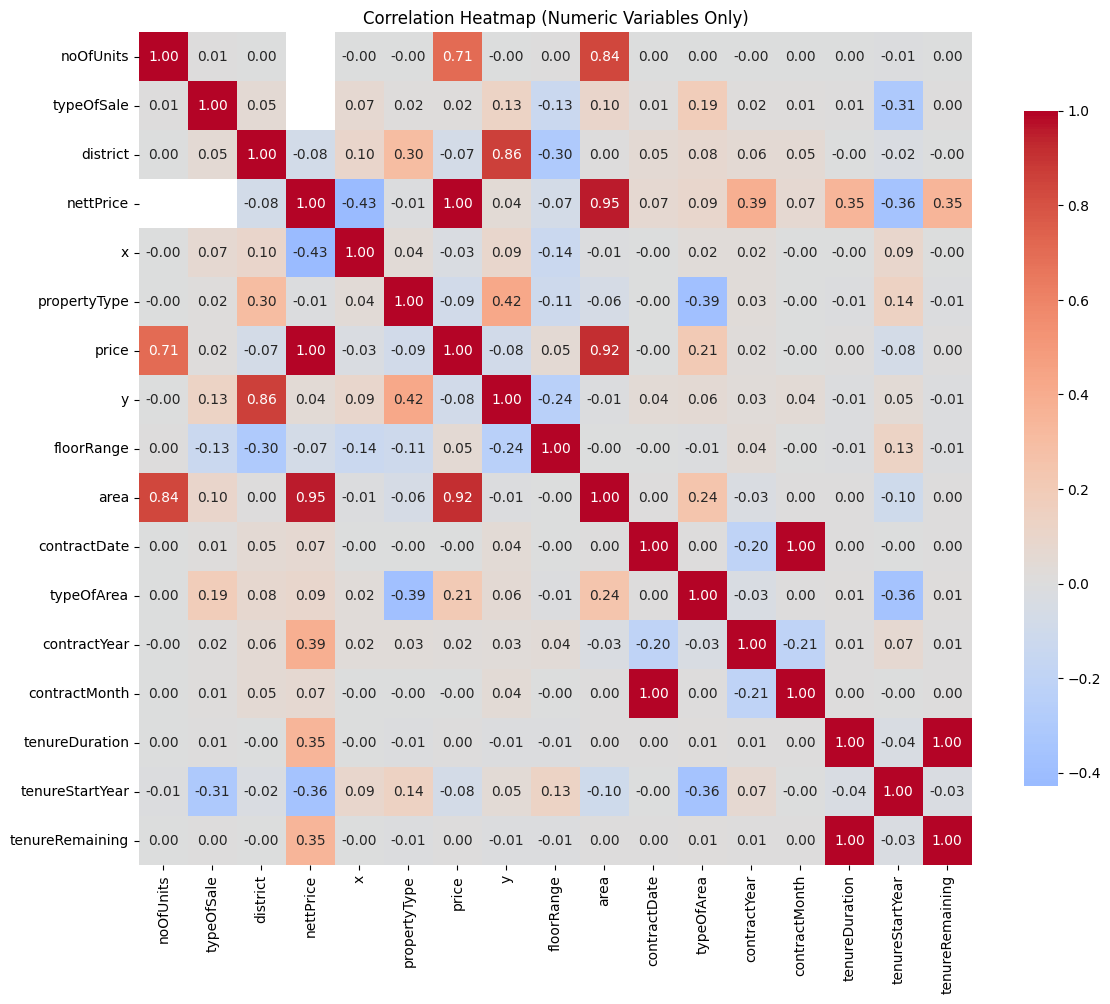

In [25]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])
non_numeric_df = df.select_dtypes(exclude=['int64', 'float64'])

print("Numeric columns available:")
print(numeric_df.columns.tolist())

print("\nNon-numeric columns available:")
print(non_numeric_df.columns.tolist())

# Calculate correlation matrix
corr = numeric_df.corr()

# print("\nCorrelation Matrix:")
# print(corr)

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap (Numeric Variables Only)')
plt.tight_layout()
plt.show()

## Studying Property Price

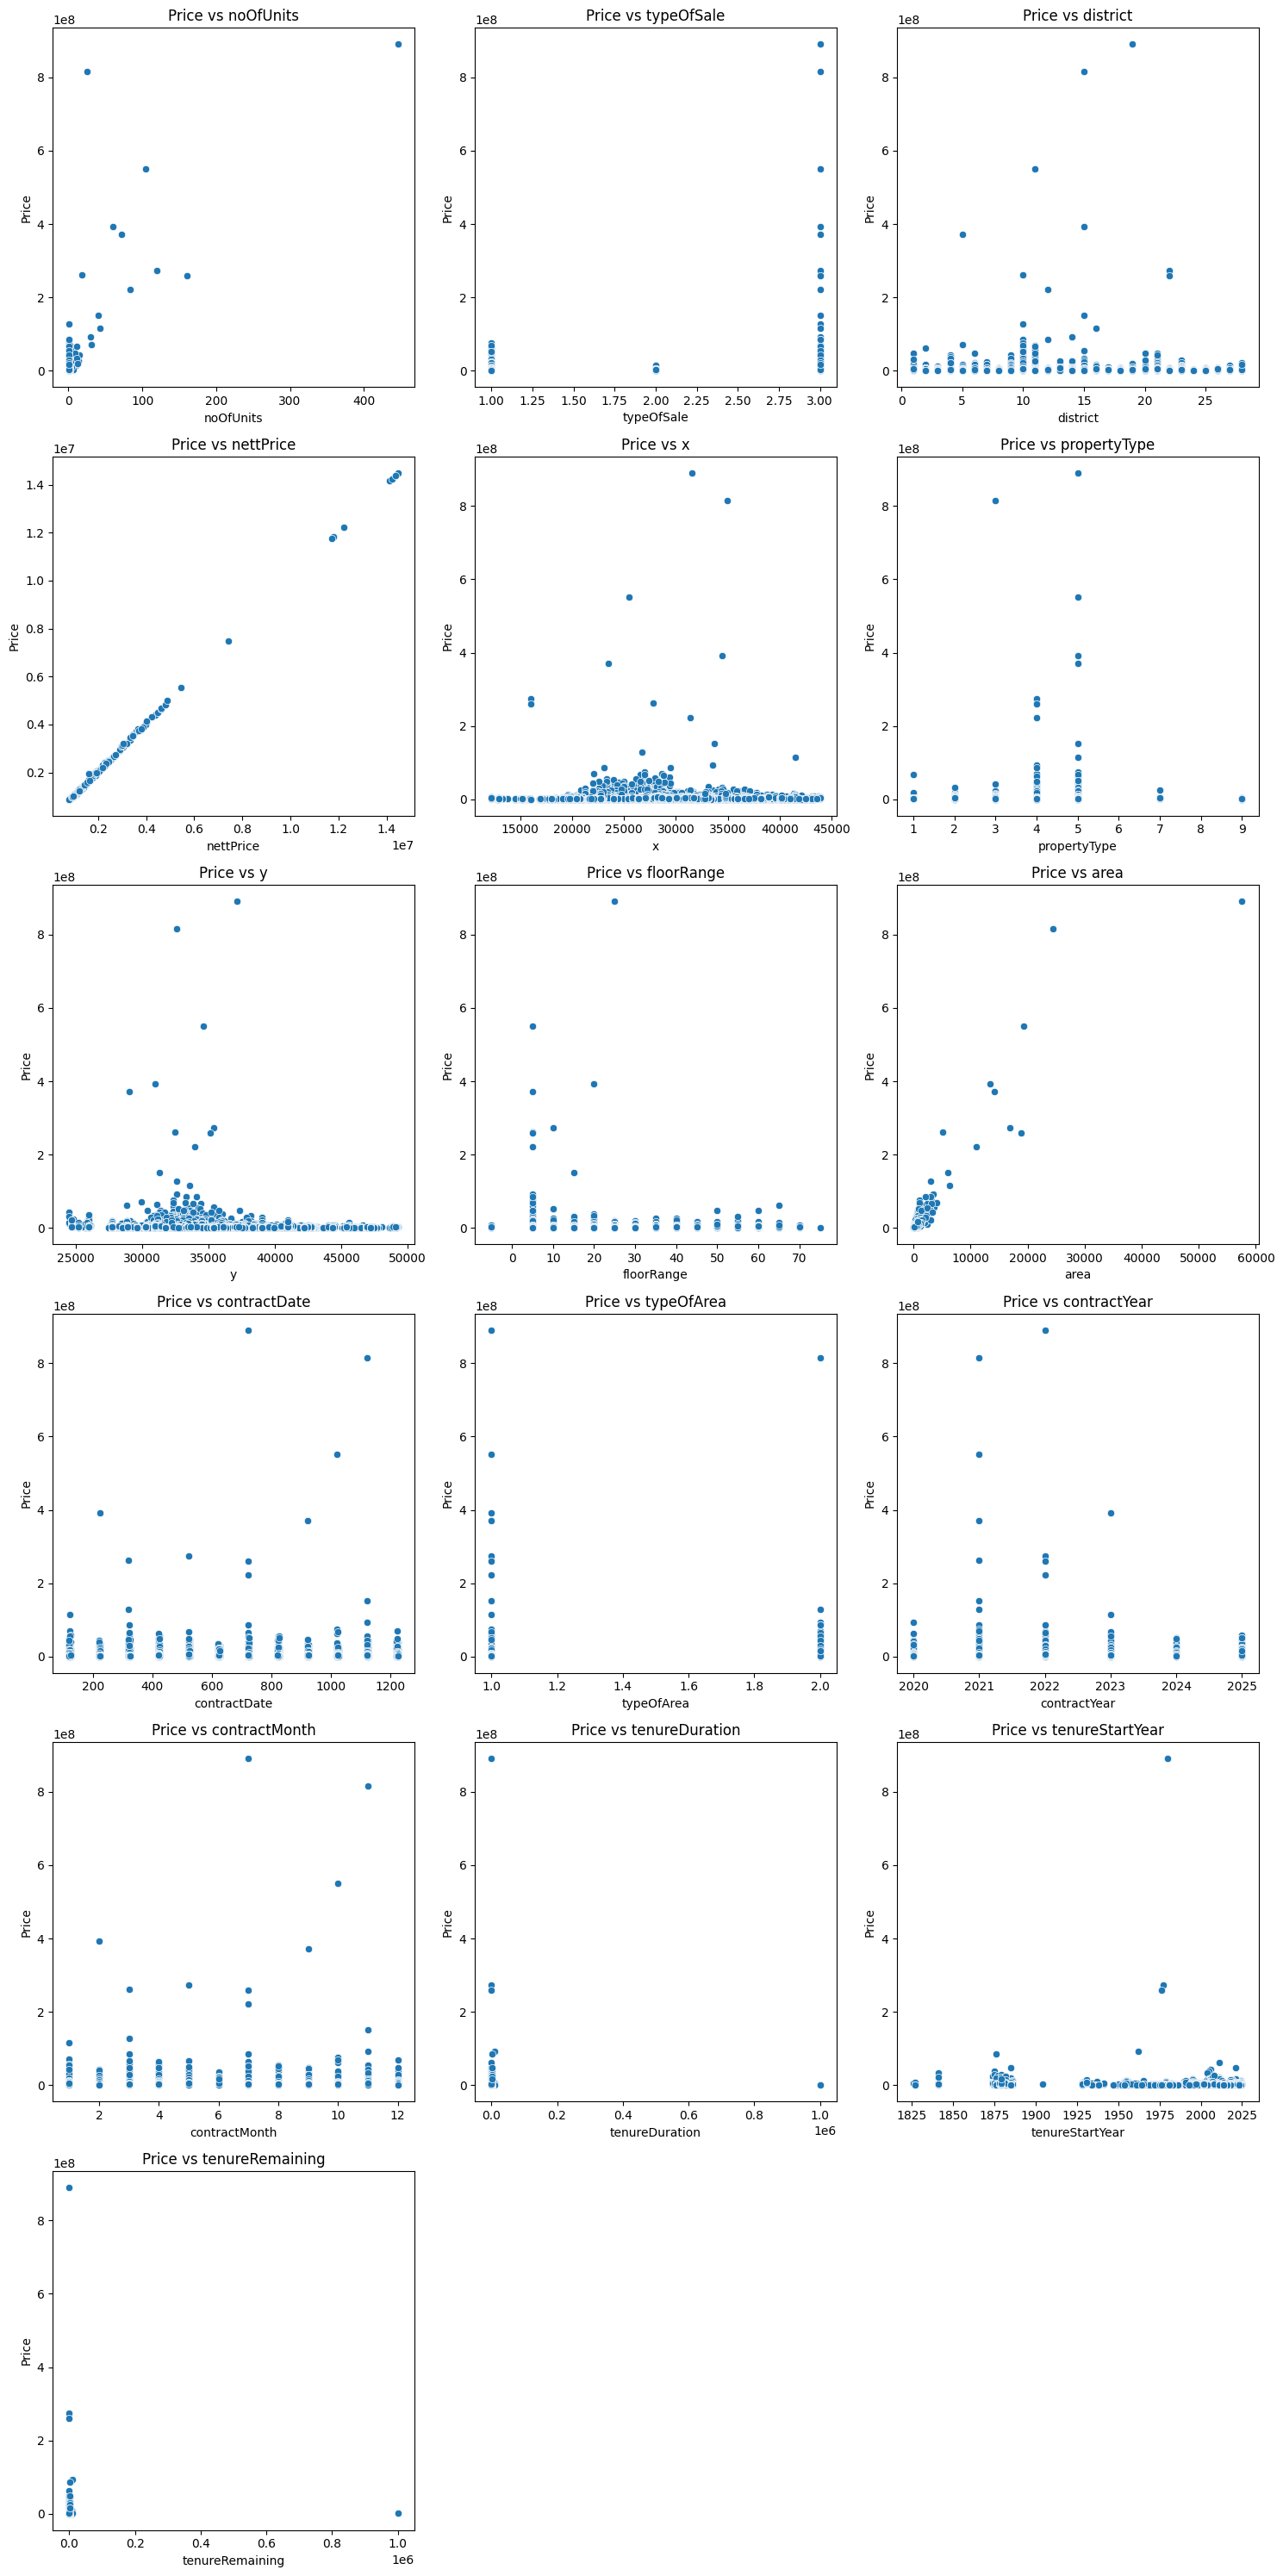

In [26]:
# Get list of numeric columns excluding 'price'
cols = [c for c in numeric_df.columns if c != 'price']
n = len(cols)

# Create subplots: 3 columns per row
rows = math.ceil(n / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten axes array for easy iteration

# Plot each feature as a boxplot
for i, col in enumerate(cols):
    sns.scatterplot(data=df, x=col, y='price', ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [27]:
categorial_cols = ['marketSegment', 'typeOfSale', 'district', 'propertyType', 'floorRange', 'typeOfArea', 'tenureRemaining']

# Find average price for each category in categorial columns
for col in categorial_cols:
    for category, group in df.groupby(col):
        avg_price = group['price'].mean()
        print(f"Average price for {col} = {category}: ${avg_price:,.2f}")
    print("\n")

Average price for marketSegment = CCR: $3,579,715.30
Average price for marketSegment = OCR: $1,749,784.13
Average price for marketSegment = RCR: $2,157,083.65


Average price for typeOfSale = 1: $2,080,393.25
Average price for typeOfSale = 2: $1,605,025.82
Average price for typeOfSale = 3: $2,219,515.97


Average price for district = 1: $2,257,666.09
Average price for district = 2: $1,916,161.93
Average price for district = 3: $2,020,232.10
Average price for district = 4: $3,256,800.56
Average price for district = 5: $1,857,237.89
Average price for district = 6: $2,934,164.65
Average price for district = 7: $2,176,180.98
Average price for district = 8: $1,634,597.13
Average price for district = 9: $2,934,818.61
Average price for district = 10: $4,147,077.82
Average price for district = 11: $4,110,405.36
Average price for district = 12: $1,770,873.26
Average price for district = 13: $2,150,134.13
Average price for district = 14: $1,593,396.02
Average price for district = 15: $2,787,785.